In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# MOUNT GOOGLE DRIVE (RUN THIS FIRST)
This cell mounts your Google Drive where the model will be saved

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Define the model save path in Google Drive
MODEL_SAVE_DIR = '/content/drive/MyDrive/Content /BRAINMRI_MODELS'
MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'trained_unet_model.keras')

# Create directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Model will be saved to: {MODEL_PATH}")

Mounted at /content/drive
Model will be saved to: /content/drive/MyDrive/Content /BRAINMRI_MODELS/trained_unet_model.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1. DATA PREPROCESSING AND LOADING

In [5]:
class BrainMRIDataLoader:
    """Load and preprocess brain MRI data from MSSEG dataset"""

    def __init__(self, data_dir, target_shape=(128, 128, 128)):
        self.data_dir = data_dir
        self.target_shape = target_shape

    def load_nifti(self, filepath):
        """Load NIfTI file and return numpy array"""
        try:
            img = nib.load(filepath)
            data = img.get_fdata()
            return data
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None

    def normalize_volume(self, volume):
        """Normalize volume with percentile clipping and z-score normalization"""
        volume = volume.astype(np.float32)

        # Remove outliers using percentile clipping
        p1, p99 = np.percentile(volume[volume > 0], [1, 99])
        volume = np.clip(volume, p1, p99)

        # Z-score normalization
        mean = np.mean(volume[volume > 0])
        std = np.std(volume[volume > 0])
        if std > 0:
            volume = (volume - mean) / std

        # Scale to [0, 1]
        min_val = np.min(volume)
        max_val = np.max(volume)
        if max_val - min_val > 0:
            volume = (volume - min_val) / (max_val - min_val)

        return volume

    def resize_volume(self, volume, target_shape):
        """Resize 3D volume to target shape"""
        factors = [t / s for t, s in zip(target_shape, volume.shape)]
        return zoom(volume, factors, order=1)

    def load_patient_data(self, patient_folder):
        """Load all modalities for a single patient"""
        patient_id = os.path.basename(patient_folder)
        base_name = patient_id.split('-')[1] if '-' in patient_id else '1'

        # Define file patterns
        modalities = {
            'flair': f'{base_name}-Flair.nii',
            't1': f'{base_name}-T1.nii',
            't2': f'{base_name}-T2.nii',
            'lesion_seg': f'{base_name}-LesionSeg-Flair.nii'
        }

        data = {}
        for key, filename in modalities.items():
            filepath = os.path.join(patient_folder, filename)
            if os.path.exists(filepath):
                volume = self.load_nifti(filepath)
                if volume is not None:
                    # Normalize and resize
                    volume = self.normalize_volume(volume)
                    volume = self.resize_volume(volume, self.target_shape)
                    data[key] = volume

        return data if len(data) > 0 else None

    def load_dataset(self):
        """Load entire dataset"""
        X_flair, X_t1, X_t2, y = [], [], [], []

        # Iterate through all patient folders
        for patient_folder in sorted(os.listdir(self.data_dir)):
            patient_path = os.path.join(self.data_dir, patient_folder)
            if os.path.isdir(patient_path):
                print(f"Loading {patient_folder}...")
                patient_data = self.load_patient_data(patient_path)

                if patient_data and 'flair' in patient_data and 'lesion_seg' in patient_data:
                    X_flair.append(patient_data['flair'])
                    X_t1.append(patient_data.get('t1', np.zeros(self.target_shape)))
                    X_t2.append(patient_data.get('t2', np.zeros(self.target_shape)))

                    # Binarize segmentation mask
                    mask = patient_data['lesion_seg']
                    mask = (mask > 0).astype(np.float32)
                    y.append(mask)

        # Convert to numpy arrays with explicit dtype
        X_flair = np.array(X_flair, dtype=np.float32)[..., np.newaxis]
        X_t1 = np.array(X_t1, dtype=np.float32)[..., np.newaxis]
        X_t2 = np.array(X_t2, dtype=np.float32)[..., np.newaxis]
        y = np.array(y, dtype=np.float32)[..., np.newaxis]

        # Concatenate modalities
        X = np.concatenate([X_flair, X_t1, X_t2], axis=-1)

        return X, y

# 2. DATA AUGMENTATION

In [6]:
def augment_volume(volume, mask):
    """Apply random augmentations to volume and mask"""
    # Random intensity scaling for contrast
    if np.random.random() > 0.5:
        scale = np.random.uniform(0.8, 1.2)
        volume = volume * scale
        volume = np.clip(volume, 0, 1)

    # Random gamma correction
    if np.random.random() > 0.5:
        gamma = np.random.uniform(0.8, 1.2)
        volume = np.power(volume, gamma)

    # Random rotation (90 degrees)
    k = np.random.randint(0, 4)
    volume = np.rot90(volume, k, axes=(0, 1))
    mask = np.rot90(mask, k, axes=(0, 1))

    # Add random noise
    noise = np.random.normal(0, 0.01, volume.shape)
    volume = volume + noise
    volume = np.clip(volume, 0, 1)

    return volume, mask

# 3. MODEL ARCHITECTURE - 3D U-NET WITH ATTENTION

In [7]:
def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    """Convolutional block with optional batch normalization"""
    x = layers.Conv3D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    """Encoder block with two convolutions and max pooling"""
    conv = conv_block(x, filters)
    conv = conv_block(conv, filters)
    pool = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv)
    return conv, pool

def decoder_block(x, skip, filters):
    """Decoder block with upsampling and skip connections"""
    x = layers.Conv3DTranspose(filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x

def attention_gate(x, g, filters):
    """Attention gate for focusing on relevant features"""
    theta_x = layers.Conv3D(filters, 1, strides=(2, 2, 2), padding='same')(x)
    phi_g = layers.Conv3D(filters, 1, padding='same')(g)

    add = layers.Add()([theta_x, phi_g])
    add = layers.Activation('relu')(add)

    psi = layers.Conv3D(1, 1, padding='same')(add)
    psi = layers.Activation('sigmoid')(psi)
    psi = layers.UpSampling3D(size=(2, 2, 2))(psi)

    return layers.Multiply()([x, psi])

def build_3d_unet(input_shape=(128, 128, 128, 3), num_classes=1, use_attention=True):
    """
    Build 3D U-Net model with optional attention gates
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder path
    conv1, pool1 = encoder_block(inputs, 32)
    conv2, pool2 = encoder_block(pool1, 64)
    conv3, pool3 = encoder_block(pool2, 128)
    conv4, pool4 = encoder_block(pool3, 256)

    # Bottleneck
    bottleneck = conv_block(pool4, 512)
    bottleneck = conv_block(bottleneck, 512)

    # Decoder path with attention
    if use_attention:
        conv4 = attention_gate(conv4, bottleneck, 256)
    dec4 = decoder_block(bottleneck, conv4, 256)

    if use_attention:
        conv3 = attention_gate(conv3, dec4, 128)
    dec3 = decoder_block(dec4, conv3, 128)

    if use_attention:
        conv2 = attention_gate(conv2, dec3, 64)
    dec2 = decoder_block(dec3, conv2, 64)

    if use_attention:
        conv1 = attention_gate(conv1, dec2, 32)
    dec1 = decoder_block(dec2, conv1, 32)

    # Output layer
    outputs = layers.Conv3D(num_classes, 1, activation='sigmoid', padding='same')(dec1)

    model = models.Model(inputs=inputs, outputs=outputs, name='3D_UNet_Attention')
    return model

# 4. CUSTOM LOSSES AND METRICS

In [8]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for binary segmentation"""
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss for training"""
    return 1 - dice_coefficient(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal loss for handling class imbalance"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reshape(bce, [-1])

    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    focal = alpha_t * tf.pow(1 - p_t, gamma) * bce

    return tf.reduce_mean(focal)

def combined_loss(y_true, y_pred):
    """Combined focal and dice loss with weighting"""
    focal = focal_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * focal + 0.5 * dice

def iou_metric(y_true, y_pred, threshold=0.5):
    """Intersection over Union metric"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)

# 5. TRAINING UTILITIES

In [9]:
class DataGenerator(keras.utils.Sequence):
    """Custom data generator for training with augmentation"""

    def __init__(self, X, y, batch_size=2, augment=True, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = np.empty((self.batch_size, *self.X.shape[1:]))
        y_batch = np.empty((self.batch_size, *self.y.shape[1:]))

        for i, idx in enumerate(indexes):
            x, y = self.X[idx], self.y[idx]
            if self.augment:
                x, y = augment_volume(x, y)
            X_batch[i] = x
            y_batch[i] = y

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 6. INFERENCE ON CUSTOM DATA

In [10]:
def predict_on_custom_data(model, patient_folder, loader):
    """
    Make prediction on a new patient scan
    """
    print(f"\nPredicting on: {patient_folder}")

    # Load patient data
    patient_data = loader.load_patient_data(patient_folder)

    if patient_data is None or 'flair' not in patient_data:
        print("Error: Could not load patient data")
        return None

    # Prepare input
    X_input = np.stack([
        patient_data.get('flair', np.zeros(loader.target_shape)),
        patient_data.get('t1', np.zeros(loader.target_shape)),
        patient_data.get('t2', np.zeros(loader.target_shape))
    ], axis=-1)[np.newaxis, ...]

    # Predict
    prediction = model.predict(X_input, verbose=0)[0, :, :, :, 0]

    # Visualize
    slice_idx = prediction.shape[2] // 2

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(patient_data['flair'][:, :, slice_idx], cmap='gray')
    axes[0].set_title('FLAIR Input')
    axes[0].axis('off')

    axes[1].imshow(prediction[:, :, slice_idx], cmap='jet')
    axes[1].set_title('Predicted Lesions')
    axes[1].axis('off')

    axes[2].imshow(patient_data['flair'][:, :, slice_idx], cmap='gray')
    axes[2].imshow(prediction[:, :, slice_idx] > 0.5, cmap='jet', alpha=0.5)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return prediction

# 7. MODEL MANAGEMENT - SAVE AND LOAD
**KEY FEATURE:** Check if model exists, load it if available, otherwise train new model

In [14]:
def load_or_create_model(model_path, input_shape, force_retrain=False):
    """
    Load existing model or create new one

    Args:
        model_path: Path to saved model
        input_shape: Shape of input data
        force_retrain: If True, ignore existing model and create new one

    Returns:
        model: Loaded or newly created model
        is_pretrained: Boolean indicating if model was loaded
    """
    if os.path.exists(model_path) and not force_retrain:
        print("\n" + "="*80)
        print(" FOUND EXISTING MODEL - Loading from disk...")
        print("="*80)

        try:
            # Load model with custom objects
            model = keras.models.load_model(
                model_path,
                custom_objects={
                    'combined_loss': combined_loss,
                    'dice_coefficient': dice_coefficient,
                    'iou_metric': iou_metric
                }
            )
            print(f" Model loaded successfully from: {model_path}")
            print("\nℹ  You can now make predictions without retraining!")
            print("ℹTo retrain, set force_retrain=True\n")
            return model, True
        except Exception as e:
            print(f"  Error loading model: {e}")
            print("Building new model instead...")
    else:
        if force_retrain:
            print("\n FORCE RETRAIN enabled - Building new model...\n")
        else:
            print("\n No existing model found - Building new model...\n")

    # Build new model
    model = build_3d_unet(input_shape=input_shape, use_attention=True)

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-5),
        loss=combined_loss,
        metrics=[dice_coefficient, iou_metric]
    )

    return model, False

# 8. MAIN TRAINING AND PREDICTION PIPELINE
**Run this cell to either train or load the model**

In [15]:
# ================================
# CONFIGURATION
# ================================
DATA_DIR = '/content/drive/MyDrive/Content /MSSEG'  # Update this path
TARGET_SHAPE = (32, 32, 32)  # Smaller for faster training
BATCH_SIZE = 1
EPOCHS = 100
FORCE_RETRAIN = False  # Set to True to retrain even if model exists

print("="*80)
print("BRAIN MRI SEGMENTATION - SMART MODEL MANAGEMENT")
print("="*80)

# ================================
# STEP 1: Try to load existing model
# ================================
input_shape = (*TARGET_SHAPE, 3)
model, is_pretrained = load_or_create_model(MODEL_PATH, input_shape, FORCE_RETRAIN)

# ================================
# STEP 2: If model needs training
# ================================
if not is_pretrained:
    print("\n[1/5] Loading and preprocessing data...")
    loader = BrainMRIDataLoader(DATA_DIR, TARGET_SHAPE)
    X, y = loader.load_dataset()
    print(f"Dataset shape: X={X.shape}, y={y.shape}")

    print("\n[2/5] Splitting data...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    print("\n[3/5] Creating data generators...")
    train_gen = DataGenerator(X_train, y_train, batch_size=BATCH_SIZE, augment=True)
    val_gen = DataGenerator(X_val, y_val, batch_size=BATCH_SIZE, augment=False)

    print("\n[4/5] Setting up callbacks...")
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            MODEL_PATH,
            monitor='val_dice_coefficient',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7
        )
    ]

    print("\n[5/5] Training model...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    print("\n" + "="*80)
    print("TRAINING COMPLETE!")
    print(f"Model saved to: {MODEL_PATH}")
    print(" Next time you run this notebook, the model will load automatically!")
    print("="*80)

print("\n Model is ready for predictions!")

BRAIN MRI SEGMENTATION - SMART MODEL MANAGEMENT

 FOUND EXISTING MODEL - Loading from disk...
 Model loaded successfully from: /content/drive/MyDrive/Content /BRAINMRI_MODELS/trained_unet_model.keras

ℹ  You can now make predictions without retraining!
ℹTo retrain, set force_retrain=True


 Model is ready for predictions!


# 9. MAKE PREDICTIONS ON CUSTOM DATA
**Run this cell anytime to make predictions (no retraining needed!)**

MAKING PREDICTION ON CUSTOM DATA

Predicting on: /content/drive/MyDrive/Content /MSSEG/Patient-10


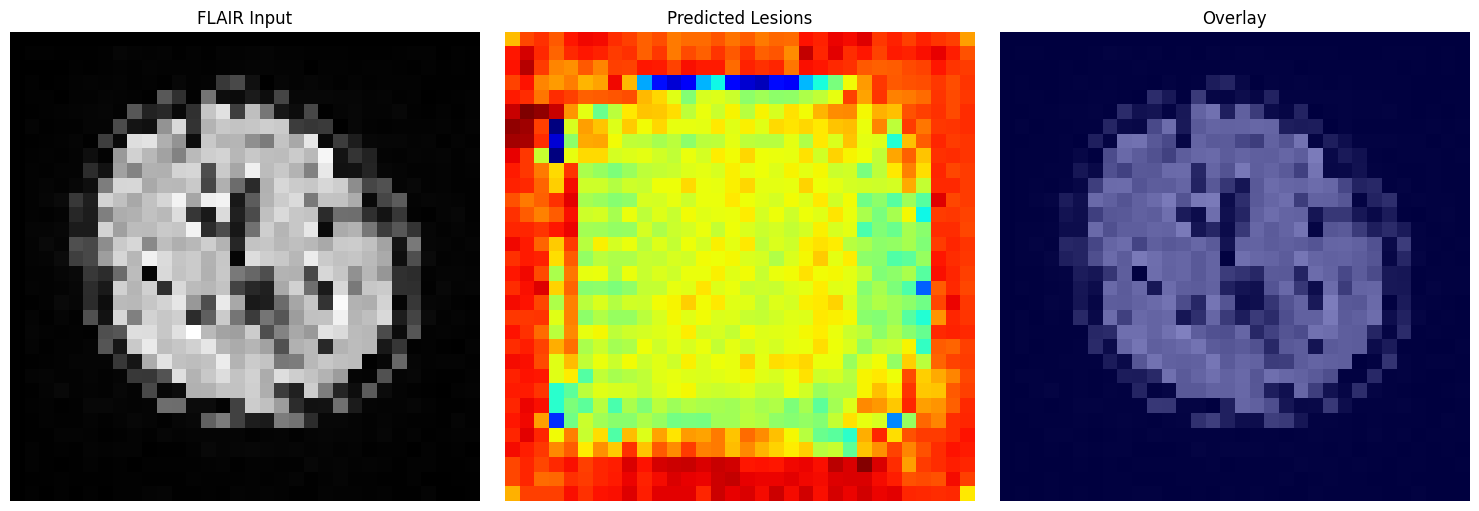


Prediction successful!
Prediction shape: (32, 32, 32)
Lesion pixels detected: 32731


In [26]:
# ================================
# PREDICTION CONFIGURATION
# ================================
PATIENT_FOLDER = '/content/drive/MyDrive/Content /MSSEG/Patient-10'  # Update this path

print("="*80)
print("MAKING PREDICTION ON CUSTOM DATA")
print("="*80)

# Load model if not already loaded
if 'model' not in locals():
    print("Loading model...")
    model, _ = load_or_create_model(MODEL_PATH, (*TARGET_SHAPE, 3), force_retrain=False)

# Initialize data loader
loader = BrainMRIDataLoader(DATA_DIR, TARGET_SHAPE)

# Make prediction
if os.path.exists(PATIENT_FOLDER):
    pred_mask = predict_on_custom_data(model, PATIENT_FOLDER, loader)

    if pred_mask is not None:
        print("\nPrediction successful!")
        print(f"Prediction shape: {pred_mask.shape}")
        print(f"Lesion pixels detected: {np.sum(pred_mask > 0.5)}")
else:
    print(f"\nError: Patient folder not found: {PATIENT_FOLDER}")
    print("Please update PATIENT_FOLDER path")

# 10. CHATBOT FOR MEDICAL INSIGHTS
**Get AI-powered analysis and recommendations based on predictions**

In [21]:
from google.colab import userdata

In [ ]:
from datetime import datetime
from openai import OpenAI

# Initialize OpenAI client (replace with your API key)
client = OpenAI(api_key="")

# Helper Functions
def calculate_lesion_percentage(pred_mask):
    """Calculate percentage of lesion pixels in the mask."""
    if pred_mask is None:
        return 0.0
    total_pixels = pred_mask.size
    lesion_pixels = np.sum(pred_mask > 0.5)
    percentage = (lesion_pixels / total_pixels) * 100
    return round(percentage, 2)

def get_severity_level(percentage):
    """Map lesion percentage to severity category."""
    if percentage < 1:

        return "very mild"
    elif percentage < 5:
        return "mild"
    elif percentage < 15:
        return "moderate"
    else:
        return "severe"

def get_basic_advice(severity):
    """Provide rule-based next steps based on severity."""
    advice_map = {
        "very mild": "Monitor symptoms. Maintain healthy lifestyle. Follow up with doctor if symptoms worsen.",
        "mild": "Schedule a consultation with a neurologist. Keep a symptom diary. Stay hydrated and get adequate rest.",
        "moderate": "Seek medical evaluation soon. Discuss treatment options with your doctor. Avoid stress and maintain regular sleep.",
        "severe": "Consult a neurologist urgently. Immediate medical attention recommended. Follow prescribed treatment plan closely."
    }
    return advice_map.get(severity, "Consult with a healthcare professional.")

# Conversation Memory
conversation_history = []

def add_to_history(role, content):
    """Add message to conversation history."""
    conversation_history.append({
        "role": role,
        "content": content,
        "timestamp": datetime.now().strftime("%H:%M:%S")
    })

def get_conversation_context():
    """Return formatted conversation history for LLM."""
    return [{"role": msg["role"], "content": msg["content"]}
            for msg in conversation_history]

def generate_patient_summary(percentage, severity, advice):
    """Use OpenAI to generate patient-friendly summary."""
    system_prompt = f"""You are a supportive medical information assistant.

Current analysis results:
- Lesion percentage: {percentage}%
- Severity: {severity}
- Recommended actions: {advice}

Provide helpful, specific recommendations when asked about exercises, diet, or lifestyle.
Be supportive and practical."""

    user_prompt = f"""
    Based on MRI analysis:
    - Lesion coverage: {percentage}%
    - Severity: {severity}
    - Recommended next steps: {advice}

    Provide a brief, compassionate summary for the patient. Keep it under 150 words.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-5-nano",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=1
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error generating summary: {str(e)}"

def chatbot_response(user_question, percentage, severity, advice):
    """Generate chatbot response using conversation history."""
    add_to_history("user", user_question)

    system_prompt = f"""You are a supportive medical information assistant.

    Current analysis results:
    - Lesion percentage: {percentage}%
    - Severity: {severity}
    - Recommended actions: {advice}

    Provide helpful, empathetic responses to patient questions."""

    try:
        messages = [{"role": "system", "content": system_prompt}] + get_conversation_context()

        response = client.chat.completions.create(
            model="gpt-5-nano",
            messages=messages,
            temperature=1

        )

        bot_message = response.choices[0].message.content.strip()
        add_to_history("assistant", bot_message)
        return bot_message
    except Exception as e:
        return f"Error: {str(e)}"

print("Chatbot functions loaded successfully!")

Chatbot functions loaded successfully!


# 11. USE THE CHATBOT
**Get insights and ask questions about your prediction**


🏥 CUSTOM MRI ANALYSIS SYSTEM (MULTI-CHANNEL)
 UPLOAD YOUR MRI SCAN FILES
IMPORTANT: Your model requires ALL 3 sequences:
   1. FLAIR sequence (lesion detection)
   2. T1 sequence
   3. T2 sequence

Please upload all 3 .nii files



Saving 10-Flair.nii to 10-Flair.nii
Saving 10-T1.nii to 10-T1.nii
Saving 10-T2.nii to 10-T2.nii

3 file(s) uploaded: ['10-Flair.nii', '10-T1.nii', '10-T2.nii']

🔍 Detected sequences:
   FLAIR: 10-Flair.nii
   T1:    10-T1.nii
   T2:    10-T2.nii

🔄 Loading and preprocessing all 3 sequences...
   FLAIR shape: (320, 280, 20)
   T1 shape:    (512, 448, 20)
   T2 shape:    (512, 464, 20)

   Resizing all to: (32, 32, 32)
   Combined input shape: (1, 32, 32, 32, 3)
   ✅ Shape is correct: (1, 32, 32, 32, 3)

🧠 Running model prediction...
✅ Prediction complete!

📸 Displaying results (3 slices)...


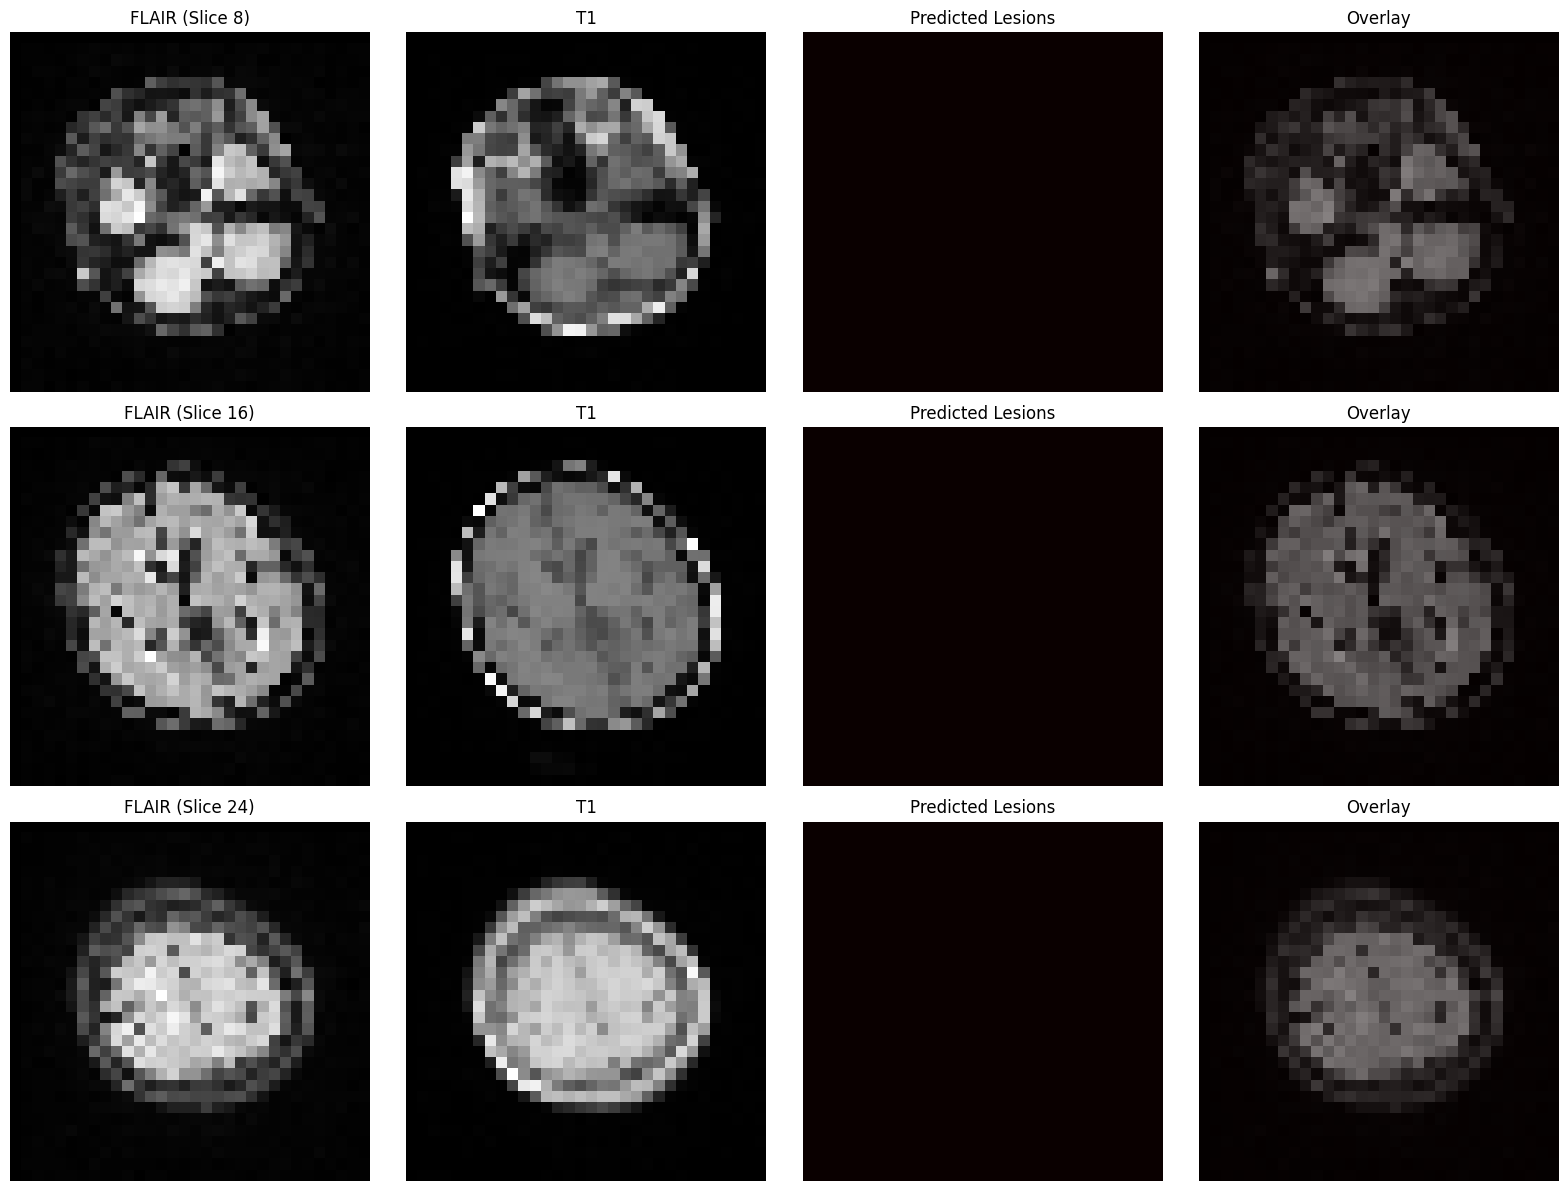


📊 ANALYSIS RESULTS
Lesion Coverage: 99.9%
Severity Level: SEVERE
Recommendation: Consult a neurologist urgently. Immediate medical attention recommended. Follow prescribed treatment plan closely.

🤖 Generating patient-friendly summary...

PATIENT-FRIENDLY SUMMARY:
Your MRI shows a very large lesion, essentially covering the analyzed area (about 99.9%). This is a serious finding that requires urgent medical evaluation by a neurologist. Please seek care as soon as possible and follow the treatment plan your doctors prescribe closely. If you notice new or worsening symptoms—sudden weakness, trouble speaking or understanding, severe headache, vision changes, dizziness, or confusion—seek emergency care immediately. Bring this MRI result to your appointment and jot down any questions you have. You’re not alone—your healthcare team is there to support you, and acting promptly now can help us manage this together.

💬 CHATBOT READY - Ask your questions!


Text(value='', description='You:', layout=Layout(width='85%'), placeholder='Type your question here...')

Output()


💡 Suggested questions:
   • What exercises can I do?
   • Can you recommend a diet plan?
   • What does this severity mean?
   • Should I be worried?

(Press Enter after typing to send)


In [27]:
# ================================================================================
# CUSTOM MRI SCAN UPLOAD & PREDICTION (MULTI-CHANNEL SUPPORT)
# ================================================================================

import nibabel as nib
from google.colab import files
import numpy as np
from scipy.ndimage import zoom
import ipywidgets as widgets # Import ipywidgets
from IPython.display import display # Import display for widgets

def predict_custom_mri_multichannel():
    """
    Upload 3 MRI sequences (FLAIR, T1, T2), combine them, and run prediction.
    """
    print("=" * 70)
    print(" UPLOAD YOUR MRI SCAN FILES")
    print("=" * 70)
    print("IMPORTANT: Your model requires ALL 3 sequences:")
    print("   1. FLAIR sequence (lesion detection)")
    print("   2. T1 sequence")
    print("   3. T2 sequence")
    print("\nPlease upload all 3 .nii files")
    print("=" * 70)
    print()

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print(" No files uploaded!")
        return None, None, None, None

    filenames = list(uploaded.keys())
    print(f"\n{len(filenames)} file(s) uploaded: {filenames}")

    # Categorize files by sequence type
    flair_file = None
    t1_file = None
    t2_file = None

    for fname in filenames:
        fname_lower = fname.lower()
        if 'flair' in fname_lower:
            flair_file = fname
        elif 't1' in fname_lower:
            t1_file = fname
        elif 't2' in fname_lower:
            t2_file = fname

    print("\n🔍 Detected sequences:")
    print(f"   FLAIR: {flair_file if flair_file else '❌ Missing'}")
    print(f"   T1:    {t1_file if t1_file else '❌ Missing'}")
    print(f"   T2:    {t2_file if t2_file else '❌ Missing'}")

    # Check if all 3 are present
    if not (flair_file and t1_file and t2_file):
        print("\n❌ ERROR: Model requires all 3 sequences!")
        print("\nPlease upload:")
        if not flair_file:
            print("   • A FLAIR sequence file (e.g., 1-Flair.nii)")
        if not t1_file:
            print("   • A T1 sequence file (e.g., 1-T1.nii)")
        if not t2_file:
            print("   • A T2 sequence file (e.g., 1-T2.nii)")
        return None, None, None, None

    try:
        print("\n🔄 Loading and preprocessing all 3 sequences...")

        # Load all 3 sequences
        flair_img = nib.load(flair_file).get_fdata()
        t1_img = nib.load(t1_file).get_fdata()
        t2_img = nib.load(t2_file).get_fdata()

        print(f"   FLAIR shape: {flair_img.shape}")
        print(f"   T1 shape:    {t1_img.shape}")
        print(f"   T2 shape:    {t2_img.shape}")

        # Normalize each sequence to 0-1
        flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
        t1_img = (t1_img - np.min(t1_img)) / (np.max(t1_img) - np.min(t1_img) + 1e-8)
        t2_img = (t2_img - np.min(t2_img)) / (np.max(t2_img) - np.min(t2_img) + 1e-8)

        # Resize all to target shape
        print(f"\n   Resizing all to: {TARGET_SHAPE}")

        def resize_3d(img, target_shape):
            factors = [target_shape[i] / img.shape[i] for i in range(3)]
            return zoom(img, factors, order=1)

        flair_resized = resize_3d(flair_img, TARGET_SHAPE)
        t1_resized = resize_3d(t1_img, TARGET_SHAPE)
        t2_resized = resize_3d(t2_img, TARGET_SHAPE)

        # Stack into 3-channel input
        multi_channel = np.stack([flair_resized, t1_resized, t2_resized], axis=-1)

        # Add batch dimension
        img_input = np.expand_dims(multi_channel, axis=0)

        print(f"   Combined input shape: {img_input.shape}")
        print(f"   ✅ Shape is correct: (1, 32, 32, 32, 3)")

        # Run prediction
        print("\n🧠 Running model prediction...")
        pred_mask = model.predict(img_input, verbose=0)
        pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

        print("✅ Prediction complete!")

        # Visualize
        print("\n📸 Displaying results (3 slices)...")

        slice_indices = [
            TARGET_SHAPE[2] // 4,
            TARGET_SHAPE[2] // 2,
            3 * TARGET_SHAPE[2] // 4
        ]

        fig, axes = plt.subplots(3, 4, figsize=(16, 12))

        for i, slice_idx in enumerate(slice_indices):
            # FLAIR
            axes[i, 0].imshow(flair_resized[:, :, slice_idx], cmap='gray')
            axes[i, 0].set_title(f'FLAIR (Slice {slice_idx})')
            axes[i, 0].axis('off')

            # T1 + T2 combined view
            axes[i, 1].imshow(t1_resized[:, :, slice_idx], cmap='gray')
            axes[i, 1].set_title(f'T1')
            axes[i, 1].axis('off')

            # Prediction
            axes[i, 2].imshow(pred_mask_binary[0, :, :, slice_idx, 0], cmap='hot')
            axes[i, 2].set_title(f'Predicted Lesions')
            axes[i, 2].axis('off')

            # Overlay on FLAIR
            axes[i, 3].imshow(flair_resized[:, :, slice_idx], cmap='gray')
            axes[i, 3].imshow(pred_mask_binary[0, :, :, slice_idx, 0], cmap='hot', alpha=0.5)
            axes[i, 3].set_title(f'Overlay')
            axes[i, 3].axis('off')

        plt.tight_layout()
        plt.show()

        # Calculate metrics
        lesion_pct = calculate_lesion_percentage(pred_mask_binary)
        severity = get_severity_level(lesion_pct)
        advice = get_basic_advice(severity)

        return pred_mask_binary, lesion_pct, severity, advice

    except Exception as e:
        print(f"\n❌ Error processing images: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None


# ================================================================================
# RUN CUSTOM PREDICTION & START CHATBOT
# ================================================================================

print("\n" + "=" * 70)
print("🏥 CUSTOM MRI ANALYSIS SYSTEM (MULTI-CHANNEL)")
print("=" * 70)

custom_pred, custom_pct, custom_severity, custom_advice = predict_custom_mri_multichannel()

if custom_pred is not None:
    print("\n" + "=" * 70)
    print("📊 ANALYSIS RESULTS")
    print("=" * 70)
    print(f"Lesion Coverage: {custom_pct}%")
    print(f"Severity Level: {custom_severity.upper()}")
    print(f"Recommendation: {custom_advice}")
    print("=" * 70)

    # Generate AI summary
    print("\n🤖 Generating patient-friendly summary...")
    summary = generate_patient_summary(custom_pct, custom_severity, custom_advice)
    print("\nPATIENT-FRIENDLY SUMMARY:")
    print(summary)
    print("=" * 70)

    # Reset conversation history
    conversation_history.clear()

    # Start chatbot
    print("\n💬 CHATBOT READY - Ask your questions!")
    print("=" * 70)

    # Create widgets
    text_input = widgets.Text(
        placeholder='Type your question here...',
        description='You:',
        layout=widgets.Layout(width='85%')
    )

    output_area = widgets.Output()

    def on_submit(change):
        user_question = text_input.value
        if user_question.strip():
            with output_area:
                print(f"\n🧑 You: {user_question}")
                response = chatbot_response(user_question, custom_pct, custom_severity, custom_advice)
                print(f"\n🤖 Assistant: {response}\n")
                print("-" * 70)
            text_input.value = ''

    text_input.on_submit(on_submit)

    display(text_input)
    display(output_area)

    print("\n💡 Suggested questions:")
    print("   • What exercises can I do?")
    print("   • Can you recommend a diet plan?")
    print("   • What does this severity mean?")
    print("   • Should I be worried?")
    print("\n(Press Enter after typing to send)")
else:
    print("\n⚠️ Prediction failed. Please check requirements above.")